In [1]:
import pandas as pd
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [2]:
# `PassengerId` is highly unlikely to have any impact upon survival rate.
train.drop('PassengerId', axis=1, inplace=True)
# It's unlikely that `Ticket` numbers impacted the survival rate.
train.drop('Ticket', axis=1, inplace=True)

# Repeating for the test data, but keeping `PassengerID` as we need that!
test.drop('Ticket', axis=1, inplace=True)

In [3]:
# Handle `Age` in both datasets.
train.Age.fillna(train.Age.median(), inplace=True)
test.Age.fillna(test.Age.median(), inplace=True)

# Handle `Embarked` in the training data.
train.Embarked.fillna(train.Embarked.mode()[0], inplace=True)

# Handle `Fare` in the test data.
test.Fare.fillna(test.Fare.median(), inplace=True)

In [4]:
train['Sex'] = train.Sex.map({'male': 1, 'female': 0})
test['Sex'] = test.Sex.map({'male': 1, 'female': 0})

In [5]:
import numpy as np
train['Fare'] = np.log10(train.Fare.replace(0, np.nan)).replace(np.nan, 0)
test['Fare'] = np.log10(test.Fare.replace(0, np.nan)).replace(np.nan, 0)

In [6]:
train.drop(['Age', 'SibSp', 'Parch'], axis=1, inplace=True)
test.drop(['Age', 'SibSp', 'Parch'], axis=1, inplace=True)

In [7]:
train['Cabin'] = pd.Series([x[0] if not pd.isnull(x) else 'X' for x in train.Cabin])
test['Cabin'] = pd.Series([x[0] if not pd.isnull(x) else 'X' for x in test.Cabin])

In [8]:
train['Cabin'].replace('T', 'X', inplace=True)

In [9]:
# group cabins
train['Cabin'] = train.Cabin.map({
    'B': 'One', 'D': 'One', 'E': 'One',
    'C': 'Two', 'F': 'Two',
    'A': 'Three', 'G': 'Three',
    'X': 'Four'
})

test['Cabin'] = test.Cabin.map({
    'B': 'One', 'D': 'One', 'E': 'One',
    'C': 'Two', 'F': 'Two',
    'A': 'Three', 'G': 'Three',
    'X': 'Four'
})

In [10]:
# group embarked
train['Embarked'] = train.Embarked.map({
    'S': 'One', 'Q': 'One',
    'C': 'Two'
})

test['Embarked'] = test.Embarked.map({
    'S': 'One', 'Q': 'One',
    'C': 'Two'
})

In [11]:
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

In [12]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [13]:
import seaborn as sns

train.corr().style.background_gradient(sns.diverging_palette(220, 10, as_cmap=True), axis=1)

,Survived,Pclass,Sex,Fare,Cabin_Four,Cabin_One,Cabin_Three,Cabin_Two,Embarked_One,Embarked_Two
Survived,1,-0.338481,-0.543351,0.331805,-0.319572,0.28549,0.0272706,0.130096,-0.16824,0.16824
Pclass,-0.338481,1,0.1319,-0.670489,0.722607,-0.537107,-0.156795,-0.375642,0.243292,-0.243292
Sex,-0.543351,0.1319,1,-0.264751,0.142608,-0.145489,0.0275789,-0.0571196,0.0828535,-0.0828535
Fare,0.331805,-0.670489,-0.264751,1,-0.56036,0.399484,0.0554034,0.347093,-0.261367,0.261367
Cabin_Four,-0.319572,0.722607,0.142608,-0.56036,1,-0.69805,-0.271747,-0.545846,0.210178,-0.210178
Cabin_One,0.28549,-0.537107,-0.145489,0.399484,-0.69805,1,-0.0559705,-0.112425,-0.163428,0.163428
Cabin_Three,0.0272706,-0.156795,0.0275789,0.0554034,-0.271747,-0.0559705,1,-0.0437666,-0.0678779,0.0678779
Cabin_Two,0.130096,-0.375642,-0.0571196,0.347093,-0.545846,-0.112425,-0.0437666,1,-0.0886904,0.0886904
Embarked_One,-0.16824,0.243292,0.0828535,-0.261367,0.210178,-0.163428,-0.0678779,-0.0886904,1,-1
Embarked_Two,0.16824,-0.243292,-0.0828535,0.261367,-0.210178,0.163428,0.0678779,0.0886904,-1,1


In [14]:
test_passenger_ids = test.PassengerId
test.drop('PassengerId', axis=1, inplace=True)

In [15]:
# Keeping:
# Pclass (-0.33, 0.69)
# Sex (-0.54, 0.22)
# Fare (0.33, 0.18)
train = train[['Survived', 'Pclass', 'Sex', 'Fare']]
test = test[['Pclass', 'Sex', 'Fare']]

In [16]:
features = train.drop('Survived', axis=1)
labels = train.Survived

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features[features.columns] = scaler.fit_transform(features)
test[test.columns] = scaler.transform(test)

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Random Forest: 0.8282828282828283 / {'n_estimators': 1000, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 2, 'max_depth': 10}


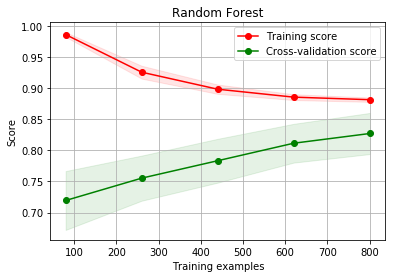

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier

kfold = StratifiedKFold(n_splits=10)

rf_params = {
    'n_estimators': [1000],
    'max_features': [1, 2, 3],
    'max_depth': [8, 10, 12, 14],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}
cv_rf = RandomizedSearchCV(
    RandomForestClassifier(bootstrap=False),
    rf_params,
    n_iter=100, cv=kfold, scoring='accuracy', random_state=42, n_jobs=-1, iid=True, refit=True)
cv_rf.fit(features, labels)
print('Random Forest: {} / {}'.format(cv_rf.best_score_, cv_rf.best_params_))

plot_learning_curve(cv_rf.best_estimator_, 'Random Forest', features, labels, cv=kfold)
plt.show()

In [26]:
predicted_survival = cv_rf.best_estimator_.predict(test)
print(predicted_survival)

submission = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Survived': predicted_survival
})
submission.to_csv('./submissions/experiment.csv', index=False)

print('Done!')

[0 1 0 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0
 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0
 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 1
 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0
 0 1 1 1 1 1 0 1 0 0 0]
Done!
